# Final project -- milestone 4

Contributor: Martin Jin, Qimei Lin, Yingxue Lu, Yuhan Zhang

Due Date: 12/11/2019

In [5]:
# import the necessary libraries
import pandas as pd
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
! pip install pandas-datareader
import pandas_datareader.data as web
import datetime
from sklearn.linear_model import LinearRegression
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsRegressor
sns.set(style="whitegrid")

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 112kB 221kB/s eta 0:00:01
     |████████████████████████████████| 8.9MB 1.9MB/s eta 0:00:01     |████▍                           | 1.2MB 249kB/s eta 0:00:31     |█████████▏                      | 2.5MB 325kB/s eta 0:00:20


## Import and Process Tweet data

1. Import Dataset from 'data/trump-tweets-11-18-2019.csv'

2. Change the data type of created_at to datetime.date

3. Restrict the dataset to original tweet only

4. Group by created_at to aggregate all tweets in a day to a single datum point.

5. Sort the Tweet data with a descending date order 

In [2]:
df_tweets = pd.read_csv('data/trump-tweets-11-18-2019.csv')
df_tweets.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,https://t.co/Mqj5tXaDAz,11-18-2019 04:38:28,15115,41938,False,1196286528546332672
1,Twitter for iPhone,“All they do is bring up witnesses who didn’t ...,11-18-2019 03:39:38,16476,61998,False,1196271720392511489
2,Twitter for iPhone,“The Impeachment started before he even became...,11-18-2019 02:40:04,18488,75282,False,1196256729471827968
3,Twitter for iPhone,https://t.co/1Rg66Tn4uP,11-17-2019 22:57:43,16318,51690,False,1196200775560634368
4,Twitter for iPhone,https://t.co/D66PEkuX6d,11-17-2019 22:51:37,12209,38663,False,1196199239715639302


In [9]:
#get the tweet data from downloaded data
df_tweets['created_at'] = pd.to_datetime(df_tweets['created_at']).dt.date
df_tweets['trump_tweet_cnt'] =[1 if reFlag ==False else 0 for reFlag in df_tweets['is_retweet'].values]
df_tweets['trump_retweet_cnt'] =[0 if  reFlag ==False else 1 for reFlag in df_tweets['is_retweet'].values]
df_tweets_cleaned = df_tweets.groupby('created_at', as_index = False).agg({
    'trump_tweet_cnt': 'sum',
    'trump_retweet_cnt': 'sum',
    'retweet_count': 'sum',
    'favorite_count': 'sum',
    'text':'sum'
})

df_tweets_cleaned= df_tweets_cleaned.sort_values('created_at',ascending=False)
df_tweets_cleaned.head()

,created_at,trump_tweet_cnt,trump_retweet_cnt,retweet_count,favorite_count,text
1018,2019-11-18,3,0,50079,179218,https://t.co/Mqj5tXaDAz“All they do is bring u...
1017,2019-11-17,36,15,666343,1668991,https://t.co/1Rg66Tn4uPhttps://t.co/D66PEkuX6d...
1016,2019-11-16,14,11,414895,932464,Louisiana 3 hours left get out and Vote for @E...
1015,2019-11-15,19,24,733886,1313131,https://t.co/8h6ZmdGlPf https://t.co/shaijXMXl...
1014,2019-11-14,13,21,444871,988437,....We send our deepest condolences to the fam...


### Import lexicon polarity data. The polarity file was adopted from vader Sentiment: https://github.com/cjhutto/vaderSentiment.git

In [7]:
sent = pd.read_csv('data/vader_lexicon.txt', sep='\t', header=None)
sent = sent.drop([2, 3], 1)
sent.index.rename('token', inplace=True)
sent.rename(columns={1: 'polarity'}, inplace=True)
sent.head()

,0,polarity
token,,
0,$:,-1.5
1,%),-0.4
2,%-),-1.5
3,&-:,-0.4
4,&:,-0.7


### The following section puts polarity and tag information into Trump's sweet data set

In [8]:
trump_tweets = pd.read_csv('data/trump-tweet-in-office.csv')
trump_tweets['created_at'] =  pd.to_datetime(trump_tweets['created_at']).dt.date

trump = trump_tweets.copy()
trump['id']=trump['id_str']
trump = trump.set_index(['id'])

repl_punc = trump['text'].str.replace(r"[?|,|$|!|&|.|#|^|;|:|/|\"]", ' ')
replacequotes = repl_punc.str.replace(r'^"', '')

# Save your regex in punct_re
punct_re = r"[^\w\s]"
#[?|,|$|!|&|.|#|^|;|:|/|\"]
trump['no_punc'] = trump['text'].str.replace(punct_re, " ")

In [6]:
trumpcopy = trump.copy()
changed_punc = trumpcopy['no_punc'].str.replace('\s+', ' ')
trumpcopy['no_punc'] = changed_punc
splt = trumpcopy['no_punc'].str.split(expand=True).stack().reset_index().set_index('id')
splt.columns = ['num', 'word']

In [7]:
splt.head(10)


,num,word
id,,
1187551862616141824,0,RT
1187551862616141824,1,RepLeeZeldin
1187551862616141824,2,This
1187551862616141824,3,impeachment
1187551862616141824,4,inquiry
1187551862616141824,5,has
1187551862616141824,6,produced
1187551862616141824,7,NOTHING
1187551862616141824,8,to


In [8]:
tidy_format = splt
newt = tidy_format.reset_index()
newsent = sent.reset_index().rename(columns = {'token': 'word'})
display(newt.head())
display(newsent.head())

,id,num,word
0,1187551862616141824,0,RT
1,1187551862616141824,1,RepLeeZeldin
2,1187551862616141824,2,This
3,1187551862616141824,3,impeachment
4,1187551862616141824,4,inquiry


,word,0,polarity
0,0,$:,-1.5
1,1,%),-0.4
2,2,%-),-1.5
3,3,&-:,-0.4
4,4,&:,-0.7


In [9]:
newt = tidy_format.reset_index()
#newt = newt.drop('num')
newt1 = newt[['id', 'word']].copy()
newsent = sent.reset_index().rename(columns = {0: 'word'})
newsent1 =newsent[['polarity', 'word']].copy()
display(newt1.head())
display(newsent1.head(10))

,id,word
0,1187551862616141824,RT
1,1187551862616141824,RepLeeZeldin
2,1187551862616141824,This
3,1187551862616141824,impeachment
4,1187551862616141824,inquiry


,polarity,word
0,-1.5,$:
1,-0.4,%)
2,-1.5,%-)
3,-0.4,&-:
4,-0.7,&:
5,1.6,( '}{' )
6,-0.9,(%
7,2.2,('-:
8,2.3,(':
9,2.1,((-:


In [10]:
polar = pd.merge(newt1, newsent1, how='outer', on= 'word')
newpol = polar.groupby('id').sum()
###newpol = newpol.drop('num', 1).fillna(0)
newpol = newpol.fillna(0)

In [11]:
polarities = newpol
maybpol = polarities.reset_index()
maybtrump = trump.reset_index()

In [12]:
display(maybpol.head())
display(maybtrump.head())

,id,polarity
0,8.222424e+17,1.7
1,8.222987e+17,2.7
2,8.224214e+17,-1.0
3,8.225018e+17,1.7
4,8.225019e+17,1.4


,id,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,no_punc
0,1187551862616141824,Twitter for iPhone,RT @RepLeeZeldin: This impeachment inquiry has...,2019-10-25,8819,0,True,1187551862616141824,RT RepLeeZeldin This impeachment inquiry has...
1,1187551461808492544,Twitter for iPhone,RT @RepDougCollins: Democrats have no concern ...,2019-10-25,13713,0,True,1187551461808492544,RT RepDougCollins Democrats have no concern ...
2,1187551451775750144,Twitter for iPhone,RT @RepGosar: The only reason Adam Schiff is c...,2019-10-25,10961,0,True,1187551451775750144,RT RepGosar The only reason Adam Schiff is c...
3,1187551305281212416,Twitter for iPhone,RT @RepArrington: Let's call this sham what it...,2019-10-25,4547,0,True,1187551305281212416,RT RepArrington Let s call this sham what it...
4,1187551256371515392,Twitter for iPhone,RT @RepMattGaetz: Democrats are trying to use ...,2019-10-25,10491,0,True,1187551256371515392,RT RepMattGaetz Democrats are trying to use ...


In [13]:
senti = pd.merge(maybpol, maybtrump, how='outer', on='id').set_index('id')
new_senti= senti.loc[senti['favorite_count']>=0].drop('id_str',axis=1)
print(len(maybtrump),len(new_senti))
display(new_senti.head())

11568 11568


,polarity,source,text,created_at,retweet_count,favorite_count,is_retweet,no_punc
id,,,,,,,,
8.225021e+17,3.7,Twitter for iPhone,What truly matters is not which party controls...,2017-01-20,42790.0,180394.0,False,What truly matters is not which party controls...
8.225026e+17,3.9,Twitter for iPhone,We will bring back our jobs. We will bring bac...,2017-01-20,37458.0,173821.0,False,We will bring back our jobs We will bring bac...
8.225029e+17,0.0,Twitter for iPhone,We will follow two simple rules: BUY AMERICAN ...,2017-01-20,38092.0,161358.0,False,We will follow two simple rules BUY AMERICAN ...
8.225041e+17,0.0,Twitter for iPhone,So to all Americans in every city near and far...,2017-01-20,14039.0,86467.0,False,So to all Americans in every city near and far...
8.226691e+17,2.7,Twitter for iPhone,THANK YOU for another wonderful evening in Was...,2017-01-21,52468.0,289942.0,False,THANK YOU for another wonderful evening in Was...


### The following section focuses on adding keyword tags to the dataset

In [14]:
keytags_politics_partisans =['crooked hilary|joe biden|obama administration|CORRUPTION','mexican wall','immigration|election medling|gun control','Nancy Pelsi','dem\W','dem party','impeach|impeachment','Russia','Putin'
                             ,'fake news']
keytags_foreign_policys =['ceasefire zones|USA soldiers|ISIS[\W]|Endless Wars','Nato\W','Middle East','Israel','Saudi\W','iran\W','iraq\W','middel east','missle'
                          ,'japan\W','korean','Mexican[\w\W]+Wall','Syria','Rocket Man','Turkey|Turks[\W|Syria|Kurdish|Kurd[\W]','china\W']
keytags_trade_war =['tpp','currency manipulate|currency manipulation','wto','unfair[\w\W]+trade'
                    ,'trade deficits|trade deficit','trade deal|trade deals','china[\w\W]+trade','trade','china','tariff'
                    ,'american[\w\W]+manufac','american first','free fair|SMART TRADE']
keytags_trade_war_senti =['worst trade deal|STUPID TRADE','currency manipulate|currency manipulation','china[\w\W]+tariff','new tariff|increase tariff','unfair[\w\W]+trade','taken advantage|taking advantage|ripped off']



trade_tags_all = []
sentiments_tags_all = []
trade_tags_score = []
foreign_policys=[]
politics_partisans=[]

foreign_tags_score_set = []
politics_tags_score_set = []

df_tweets = new_senti.copy()
counter =0

#do my own trade key tag point calculation
# regular trade key tag +1
# senti key tag +3

for i in range(len(df_tweets)) :
    #print(i)
    tagscore =0 
    politics_tag_score = 0
    foreign_tag_score = 0
    senti_tag =[]
    trade_tag =[]
    fp_tag =[]
    pp_tag =[]

    tweet_text = df_tweets.iloc[i,2]
    
    #trade tag, plus 2
    counter = 0
    for tag in keytags_trade_war:
        trade_tag = trade_tag + re.findall(tag,tweet_text, re.IGNORECASE)
        if len(trade_tag)>counter:
            counter +=1
            tagscore += 2
            print('trade tag:', i, trade_tag)
    
    #centi trade tag, plus 5
    counter = 0
    for tag in keytags_trade_war_senti:
        senti_tag = senti_tag + re.findall(tag,tweet_text, re.IGNORECASE)
        if len(senti_tag)>counter:
            counter +=1
            tagscore += 5
            print('trade centi:', i, trade_tag)
            #print(tweet_text)
    
    #foreign policy tag, plus 1
    counter = 0
    for tag in keytags_foreign_policys:
        fp_tag = fp_tag + re.findall(tag,tweet_text, re.IGNORECASE)
        if len(fp_tag)>counter:
            counter +=1
            foreign_tag_score +=1
            print('foreign policy:', i, fp_tag)
    
    for tag in keytags_politics_partisans:
        pp_tag = pp_tag + re.findall(tag,tweet_text, re.IGNORECASE)
        if len(pp_tag)>counter:
            counter +=1
            politics_tag_score +=1
            print('politics :', i, pp_tag)
            
    trade_tags_score.append(tagscore)   
    
    trade_tags_all.append(trade_tag)
    sentiments_tags_all.append(senti_tag)
    foreign_policys.append(fp_tag)
    politics_partisans.append(pp_tag)
    foreign_tags_score_set.append(foreign_tag_score)
    politics_tags_score_set.append(politics_tag_score)
print(counter)

politics : 12 ['FAKE NEWS']
trade tag: 20 ['trade deficit']
trade tag: 20 ['trade deficit', 'trade']
trade tag: 24 ['trade deficits']
trade tag: 24 ['trade deficits', 'trade']
trade centi: 24 ['trade deficits', 'trade']
politics : 29 ['FAKE NEWS']
politics : 32 ['FAKE NEWS']
foreign policy: 33 ['ISIS ']
politics : 43 ['Obama Administration']
foreign policy: 45 ['Iran ']
foreign policy: 46 ['Iran ', 'Iran ']
foreign policy: 46 ['Iran ', 'Iran ']
foreign policy: 47 ['Iran ']
politics : 48 ['FAKE NEWS']
politics : 54 ['FAKE NEWS']
politics : 60 ['fake news']
foreign policy: 62 ['Iran ']
politics : 62 ['Russia', 'Putin']
politics : 70 ['FAKE NEWS']
trade tag: 74 ['China']
foreign policy: 74 ['China ']
politics : 86 ['fake news']
politics : 87 ['Russia']
politics : 88 ['Russia']
politics : 92 ['FAKE NEWS']
politics : 98 ['FAKE NEWS']
politics : 100 ['fake news']
politics : 112 ['FAKE NEWS']
politics : 127 ['Russia']
politics : 128 ['Obama Administration']
politics : 128 ['Obama Administrati

politics : 1063 ['Fake News']
politics : 1065 ['Fake News']
foreign policy: 1072 ['isis ']
politics : 1079 ['Fake News']
trade tag: 1088 ['trade']
foreign policy: 1088 ['Iran ', 'Iran!']
foreign policy: 1088 ['Iran ', 'Iran!']
trade tag: 1099 ['TPP']
politics : 1106 ['Fake News']
politics : 1120 ['Russia']
foreign policy: 1123 ['ISIS ']
politics : 1124 ['Fake News']
politics : 1131 ['Fake News']
politics : 1132 ['Fake News']
foreign policy: 1133 ['ISIS ']
politics : 1134 ['Fake News']
foreign policy: 1138 ['ISIS ']
politics : 1140 ['FAKE NEWS']
foreign policy: 1144 ['Iran ']
politics : 1161 ['Russia']
politics : 1164 ['Dem ']
politics : 1164 ['Dem ', 'Russia']
politics : 1167 ['Russia']
politics : 1169 ['Fake News']
politics : 1178 ['Russia', 'Russia']
politics : 1178 ['Russia', 'Russia']
politics : 1182 ['Fake News']
politics : 1184 ['corruption']
foreign policy: 1188 ['ISIS ']
foreign policy: 1188 ['ISIS ', 'Middle East']
foreign policy: 1200 ['ISIS ']
politics : 1209 ['Dem ']
foreig

trade centi: 1687 ['unfair trade and bad policy with countries from around the world. We must not let our country companies and workers be taken advantage of any longer. We want free fair and SMART TRADE', 'trade', 'TRADE', 'free fair', 'SMART TRADE']
trade tag: 1696 ['trade']
trade tag: 1696 ['trade', 'tariff']
trade tag: 1697 ['trade deficits']
trade tag: 1697 ['trade deficits', 'trade']
trade tag: 1697 ['trade deficits', 'trade', 'Tariff']
trade tag: 1707 ['Trade Deficits', 'Trade Deficit']
trade tag: 1707 ['Trade Deficits', 'Trade Deficit']
trade tag: 1707 ['Trade Deficits', 'Trade Deficit', 'Trade', 'Trade']
trade tag: 1707 ['Trade Deficits', 'Trade Deficit', 'Trade', 'Trade']
foreign policy: 1711 ['Korean']
trade tag: 1714 ['trade']
trade tag: 1714 ['trade', 'tariff']
trade tag: 1716 ['China']
foreign policy: 1716 ['China ']
trade tag: 1717 ['trade']
trade tag: 1717 ['trade', 'tariff', 'tariff']
trade tag: 1717 ['trade', 'tariff', 'tariff']
politics : 1718 ['FAKE NEWS']
trade tag

trade tag: 2295 ['Trade']
foreign policy: 2295 ['NATO ']
foreign policy: 2296 ['NATO ']
politics : 2296 ['Russia', 'Russia']
politics : 2301 ['Russia']
politics : 2303 ['Putin']
trade tag: 2304 ['trade deal']
trade tag: 2304 ['trade deal', 'trade']
trade centi: 2304 ['trade deal', 'trade']
politics : 2305 ['Obama Administration']
politics : 2305 ['Obama Administration', 'Russia']
politics : 2307 ['Obama Administration']
politics : 2307 ['Obama Administration', 'Russia']
politics : 2308 ['Putin']
politics : 2308 ['Putin', 'Fake News', 'Fake News']
politics : 2311 ['Russia']
politics : 2314 ['Fake News', 'FAKE NEWS']
politics : 2315 ['Russia']
politics : 2315 ['Russia', 'Putin']
politics : 2317 ['Russia']
politics : 2317 ['Russia', 'Putin']
foreign policy: 2318 ['NATO ', 'NATO ']
foreign policy: 2318 ['NATO ', 'NATO ']
politics : 2322 ['Russia']
politics : 2325 ['Putin']
politics : 2325 ['Putin', 'Fake News']
politics : 2327 ['Putin']
foreign policy: 2328 ['NATO ']
politics : 2329 ['Russ

politics : 2720 ['Russia', 'Russia']
politics : 2720 ['Russia', 'Russia']
politics : 2726 ['Russia']
politics : 2733 ['corruption']
trade tag: 2736 ['China']
trade tag: 2736 ['China', 'Tariff']
trade centi: 2736 ['China', 'Tariff']
foreign policy: 2736 ['China ']
politics : 2757 ['Fake News']
politics : 2765 ['corruption']
politics : 2765 ['corruption', 'Russia']
politics : 2766 ['Russia']
politics : 2766 ['Russia', 'Fake News']
trade tag: 2780 ['Tariff', 'Tariff']
trade tag: 2780 ['Tariff', 'Tariff']
trade tag: 2789 ['China has been taking advantage of the United States on Trade']
trade tag: 2789 ['China has been taking advantage of the United States on Trade', 'Trade']
trade tag: 2789 ['China has been taking advantage of the United States on Trade', 'Trade', 'China', 'China']
trade tag: 2789 ['China has been taking advantage of the United States on Trade', 'Trade', 'China', 'China']
trade centi: 2789 ['China has been taking advantage of the United States on Trade', 'Trade', 'China', 

politics : 3495 ['Fake News']
politics : 3500 ['Russia', 'Russia', 'Russia']
politics : 3500 ['Russia', 'Russia', 'Russia']
politics : 3500 ['Russia', 'Russia', 'Russia']
foreign policy: 3501 ['isis.']
foreign policy: 3503 ['isis ']
foreign policy: 3508 ['ISIS ']
foreign policy: 3508 ['ISIS ', 'Syria']
foreign policy: 3508 ['ISIS ', 'Syria', 'Turkey']
foreign policy: 3510 ['isis ']
politics : 3530 ['Russia']
foreign policy: 3533 ['isis ']
trade tag: 3536 ['trade deal']
trade tag: 3536 ['trade deal', 'trade']
politics : 3552 ['Russia']
politics : 3554 ['Impeach', 'Impeach']
politics : 3554 ['Impeach', 'Impeach']
trade tag: 3557 ['trade deal']
trade tag: 3557 ['trade deal', 'trade']
politics : 3560 ['immigration']
politics : 3563 ['Obama Administration']
politics : 3567 ['immigration']
foreign policy: 3579 ['isis ']
politics : 3586 ['Fake News']
foreign policy: 3589 ['isis ']
politics : 3590 ['Fake News', 'Fake News']
politics : 3591 ['Putin']
politics : 3599 ['Fake News']
politics : 360

trade tag: 4378 ['China']
foreign policy: 4378 ['China ']
trade tag: 4381 ['China have held candid and constructive conversations on the status of the trade']
trade tag: 4381 ['China have held candid and constructive conversations on the status of the trade', 'trade']
trade tag: 4381 ['China have held candid and constructive conversations on the status of the trade', 'trade', 'China']
foreign policy: 4381 ['China ']
trade tag: 4382 ['China']
trade tag: 4382 ['China', 'Tariff']
foreign policy: 4382 ['China ']
politics : 4383 ['Dem ']
foreign policy: 4388 ['isis ']
politics : 4392 ['Russia']
trade tag: 4397 ['China']
foreign policy: 4397 ['China ']
politics : 4401 ['corruption']
trade tag: 4405 ['China']
foreign policy: 4405 ['China ']
politics : 4414 ['Dem ']
politics : 4417 ['Russia']
trade tag: 4421 ['China']
foreign policy: 4421 ['China ']
politics : 4423 ['Russia']
trade tag: 4430 ['China', 'China']
trade tag: 4430 ['China', 'China', 'Tariff', 'Tariff']
trade tag: 4430 ['China', 'Ch

politics : 4952 ['Joe Biden']
politics : 4952 ['Joe Biden', 'Russia']
politics : 4953 ['Joe Biden']
politics : 4953 ['Joe Biden', 'Russia']
politics : 4955 ['Joe Biden']
foreign policy: 4958 ['isis ']
politics : 4960 ['Fake News']
trade tag: 4971 ['Trade deal']
trade tag: 4971 ['Trade deal', 'Trade']
trade tag: 4977 ['Tariff']
politics : 4992 ['Fake News']
politics : 4993 ['Joe Biden']
trade tag: 5005 ['trade']
trade tag: 5012 ['trade deal']
trade tag: 5012 ['trade deal', 'trade']
foreign policy: 5015 ['isis ']
trade tag: 5021 ['Tariff']
trade tag: 5022 ['Tariff']
trade tag: 5023 ['China']
trade tag: 5023 ['China', 'Tariff']
trade centi: 5023 ['China', 'Tariff']
foreign policy: 5023 ['China ']
foreign policy: 5024 ['isis ']
trade tag: 5027 ['American Manufac']
foreign policy: 5031 ['isis ']
politics : 5045 ['Russia']
politics : 5049 ['Joe Biden']
foreign policy: 5071 ['Israel']
trade tag: 5073 ['China', 'China', 'China']
trade tag: 5073 ['China', 'China', 'China', 'Tariff', 'tariff']
t

politics : 6244 ['Fake News']
foreign policy: 6246 ['NATO.']
foreign policy: 6246 ['NATO.', 'Turkey', 'Turkey']
foreign policy: 6246 ['NATO.', 'Turkey', 'Turkey']
trade tag: 6248 ['China']
foreign policy: 6248 ['China.']
foreign policy: 6250 ['Turkey', 'Turkey']
foreign policy: 6250 ['Turkey', 'Turkey']
politics : 6252 ['FAKE NEWS']
trade tag: 6254 ['China Trade']
trade tag: 6254 ['China Trade', 'Trade']
trade tag: 6254 ['China Trade', 'Trade', 'China']
foreign policy: 6254 ['China ']
trade tag: 6255 ['China']
foreign policy: 6255 ['China ']
politics : 6266 ['Impeach']
politics : 6270 ['impeach']
politics : 6284 ['Impeach']
foreign policy: 6293 ['Endless Wars']
politics : 6295 ['Dem/']
foreign policy: 6298 ['Middle East']
politics : 6299 ['Impeach']
foreign policy: 6301 ['ISIS ']
foreign policy: 6301 ['ISIS ', 'Turkey']
politics : 6307 ['Impeach']
foreign policy: 6309 ['NATO ']
foreign policy: 6309 ['NATO ', 'Turkey', 'Turkey', 'Turkey']
foreign policy: 6309 ['NATO ', 'Turkey', 'Turkey

politics : 6823 ['impeach']
politics : 6825 ['Corruption']
politics : 6826 ['Fake News']
politics : 6833 ['Joe Biden']
politics : 6836 ['Impeach']
politics : 6839 ['Joe Biden']
politics : 6843 ['Dem ']
trade tag: 6846 ['Trade', 'Trade', 'Trade']
trade tag: 6846 ['Trade', 'Trade', 'Trade']
trade tag: 6846 ['Trade', 'Trade', 'Trade', 'Tariff']
trade tag: 6846 ['Trade', 'Trade', 'Trade', 'Tariff']
politics : 6849 ['Immigration']
politics : 6854 ['impeach']
politics : 6855 ['impeach']
politics : 6856 ['Fake News']
politics : 6862 ['impeach']
trade tag: 6878 ['China']
foreign policy: 6878 ['China ']
politics : 6879 ['Corruption']
trade tag: 6883 ['China Trade']
trade tag: 6883 ['China Trade', 'Trade']
trade tag: 6883 ['China Trade', 'Trade', 'China', 'China', 'China']
trade tag: 6883 ['China Trade', 'Trade', 'China', 'China', 'China']
trade tag: 6883 ['China Trade', 'Trade', 'China', 'China', 'China']
foreign policy: 6883 ['China ', 'China ', 'China ']
politics : 6887 ['Impeach', 'Impeach']

politics : 7567 ['Russia']
politics : 7573 ['Russia']
politics : 7578 ['Fake News']
politics : 7580 ['Immigration']
politics : 7583 ['Dem ']
politics : 7588 ['Fake News']
trade tag: 7611 ['WTO', 'WTO']
trade tag: 7611 ['WTO', 'WTO']
trade tag: 7611 ['WTO', 'WTO', 'Trade']
trade tag: 7613 ['China']
trade tag: 7613 ['China', 'Tariff', 'Tariff']
trade tag: 7613 ['China', 'Tariff', 'Tariff']
trade centi: 7613 ['China', 'Tariff', 'Tariff']
foreign policy: 7613 ['China.']
politics : 7629 ['Impeach']
politics : 7636 ['Russia']
politics : 7640 ['impeach']
politics : 7651 ['Fake News']
politics : 7657 ['Fake News']
foreign policy: 7659 ['Israel']
politics : 7662 ['Immigration']
foreign policy: 7676 ['Israel']
foreign policy: 7678 ['Israel']
politics : 7695 ['Impeach', 'Impeach']
politics : 7695 ['Impeach', 'Impeach']
politics : 7699 ['immigration']
foreign policy: 7701 ['Israel']
foreign policy: 7705 ['Israel']
foreign policy: 7706 ['Israel']
foreign policy: 7707 ['Israel']
politics : 7710 ['im

trade tag: 8248 ['China']
foreign policy: 8248 ['China ']
trade tag: 8249 ['TARIFF']
trade tag: 8250 ['China']
foreign policy: 8250 ['China ']
trade tag: 8251 ['Tariff']
politics : 8258 ['Dem ']
politics : 8258 ['Dem ', 'Russia']
trade tag: 8259 ['China']
foreign policy: 8259 ['China ']
trade tag: 8262 ['unfair trade']
trade tag: 8262 ['unfair trade', 'China’s unfair trade']
trade tag: 8262 ['unfair trade', 'China’s unfair trade', 'trade']
trade tag: 8262 ['unfair trade', 'China’s unfair trade', 'trade', 'China']
trade centi: 8262 ['unfair trade', 'China’s unfair trade', 'trade', 'China']
foreign policy: 8262 ['China’']
trade tag: 8264 ['China']
foreign policy: 8264 ['China ']
trade tag: 8270 ['TARIFF']
trade tag: 8271 ['unfair trade']
trade tag: 8271 ['unfair trade', 'China has engaged in unfair trade']
trade tag: 8271 ['unfair trade', 'China has engaged in unfair trade', 'trade']
trade tag: 8271 ['unfair trade', 'China has engaged in unfair trade', 'trade', 'China', 'China']
trade ta

politics : 8924 ['Russia']
politics : 8925 ['Russia']
politics : 8926 ['Fake News']
foreign policy: 8931 ['isis!']
trade tag: 8933 ['China posts slowest economic numbers since 1990 due to U.S. trade']
trade tag: 8933 ['China posts slowest economic numbers since 1990 due to U.S. trade', 'trade']
trade tag: 8933 ['China posts slowest economic numbers since 1990 due to U.S. trade', 'trade', 'China', 'China']
trade tag: 8933 ['China posts slowest economic numbers since 1990 due to U.S. trade', 'trade', 'China', 'China']
foreign policy: 8933 ['China ', 'China ']
trade tag: 8936 ['American Manufacturing job growth since 1997 or 21 years. The previous administration said manufac']
foreign policy: 8947 ['isis ']
politics : 8948 ['immigration']
politics : 8956 ['Fake News']
politics : 8959 ['fake news', 'fake news']
politics : 8960 ['fake news']
politics : 8962 ['fake news']
politics : 8964 ['FAKE NEWS']
foreign policy: 8966 ['isis ']
foreign policy: 8977 ['isis ']
politics : 8978 ['Putin']
for

trade tag: 9773 ['Tariff']
foreign policy: 9773 ['Turkey', 'Turkey']
foreign policy: 9773 ['Turkey', 'Turkey']
politics : 9775 ['Russia']
politics : 9779 ['Fake News']
foreign policy: 9786 ['Iran ', 'Iran ']
foreign policy: 9786 ['Iran ', 'Iran ']
politics : 9792 ['corruption']
politics : 9792 ['corruption', 'FAKE NEWS']
politics : 9793 ['Fake News']
trade tag: 9794 ['Tariff']
foreign policy: 9798 ['Iran ']
trade tag: 9799 ['China']
trade tag: 9799 ['China', 'Tariff']
trade centi: 9799 ['China', 'Tariff']
foreign policy: 9799 ['China ']
trade tag: 9800 ['Tariff', 'Tariff']
trade tag: 9800 ['Tariff', 'Tariff']
politics : 9817 ['Russia']
politics : 9822 ['Russia', 'Russia']
politics : 9822 ['Russia', 'Russia']
politics : 9823 ['Russia']
politics : 9827 ['immigration']
politics : 9830 ['Fake News']
politics : 9838 ['immigration', 'immigration']
politics : 9838 ['immigration', 'immigration']
politics : 9848 ['immigration']
politics : 9857 ['Impeach']
foreign policy: 9859 ['Turkey']
trade t

politics : 10172 ['Russia']
politics : 10172 ['Russia', 'Fake News']
politics : 10174 ['Fake News', 'Fake News']
trade tag: 10187 ['Trade']
trade tag: 10187 ['Trade', 'China']
foreign policy: 10187 ['China.']
politics : 10188 ['Fake News']
foreign policy: 10190 ['Israel']
foreign policy: 10192 ['Middle East']
foreign policy: 10192 ['Middle East', 'Iran ', 'Iran ']
foreign policy: 10192 ['Middle East', 'Iran ', 'Iran ']
trade tag: 10193 ['China and the United States are working well together on trade']
trade tag: 10193 ['China and the United States are working well together on trade', 'trade']
trade tag: 10193 ['China and the United States are working well together on trade', 'trade', 'China', 'China']
trade tag: 10193 ['China and the United States are working well together on trade', 'trade', 'China', 'China']
foreign policy: 10193 ['China ', 'China ']
trade tag: 10194 ['China', 'China']
trade tag: 10194 ['China', 'China']
foreign policy: 10194 ['China ', 'China ']
foreign policy: 1019

foreign policy: 10741 ['ISIS ']
politics : 10757 ['immigration']
politics : 10765 ['Fake News']
politics : 10769 ['Russia']
foreign policy: 10778 ['isis ']
trade tag: 10784 ['China']
foreign policy: 10784 ['China ']
trade tag: 10785 ['China to congratulate him on his extraordinary elevation. Also discussed NoKo &amp; trade']
trade tag: 10785 ['China to congratulate him on his extraordinary elevation. Also discussed NoKo &amp; trade', 'trade']
trade tag: 10785 ['China to congratulate him on his extraordinary elevation. Also discussed NoKo &amp; trade', 'trade', 'China']
foreign policy: 10785 ['China ']
politics : 10792 ['Fake News']
trade centi: 10794 []
politics : 10808 ['Russia']
politics : 10809 ['Obama Administration']
politics : 10809 ['Obama Administration', 'Russia']
foreign policy: 10811 ['Iran ']
foreign policy: 10824 ['Israel']
foreign policy: 10824 ['Israel', 'Iran ']
politics : 10834 ['Fake News']
politics : 10842 ['Fake News']
foreign policy: 10846 ['Israel']
politics : 108

In [15]:
df_tweets_padded = df_tweets.copy()
df_tweets_padded['trade_tags_score']=trade_tags_score
df_tweets_padded['foreign_tags_score']=foreign_tags_score_set
df_tweets_padded['politics_tags_score']=politics_tags_score_set
df_tweets_padded['sentiments_tags_all']=trade_tags_score

df_tweets_padded['tradetag']=trade_tags_all
df_tweets_padded['senti_tradetag']=sentiments_tags_all
df_tweets_padded['foreign_policys_tag']=foreign_policys
df_tweets_padded['politics_partisans_tag']=politics_partisans

df_tweets_padded['trump_tweet_cnt'] =[1 if reFlag ==False else 0 for reFlag in df_tweets_padded['is_retweet'].values]
df_tweets_padded['trump_retweet_cnt'] =[0 if  reFlag ==False else 1 for reFlag in df_tweets_padded['is_retweet'].values]


display(df_tweets_padded.describe())


,polarity,retweet_count,favorite_count,trade_tags_score,foreign_tags_score,politics_tags_score,sentiments_tags_all,trump_tweet_cnt,trump_retweet_cnt
count,6475.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000
mean,0.782301,18620.279046,67646.796335,0.269710,0.098634,0.136843,0.269710,0.772649,0.227351
std,3.542786,12251.542222,52250.446547,1.443753,0.384094,0.408729,1.443753,0.419139,0.419139
min,-14.900000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.600000,11411.000000,31805.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,16811.500000,69996.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2.700000,23262.750000,96769.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,20.700000,369530.000000,879647.000000,24.000000,6.000000,8.000000,24.000000,1.000000,1.000000


In [16]:
df_tweets_aggr = df_tweets_padded.groupby('created_at', as_index = False).agg({
    'trump_tweet_cnt': 'sum',
    'trump_retweet_cnt': 'sum',
    'retweet_count': 'sum',
    'favorite_count': 'sum',
    'polarity': 'sum',
    'trade_tags_score': 'sum',
    'politics_tags_score':'sum',
    'foreign_tags_score':'sum'
})
df_tweets_aggr.describe()


,trump_tweet_cnt,trump_retweet_cnt,retweet_count,favorite_count,polarity,trade_tags_score,politics_tags_score,foreign_tags_score
count,996.000000,996.000000,996.000000,9.960000e+02,996.000000,996.000000,996.000000,996.000000
mean,8.973896,2.640562,216264.445783,7.856809e+05,5.085743,3.132530,1.589357,1.145582
std,5.779475,5.852742,141487.975825,4.479941e+05,10.767604,8.300179,2.174555,2.278122
min,0.000000,0.000000,6868.000000,0.000000e+00,-43.300000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,109838.500000,4.434740e+05,-0.900000,0.000000,0.000000,0.000000
50%,8.000000,0.000000,192364.000000,7.167870e+05,3.450000,0.000000,1.000000,0.000000
75%,12.000000,2.000000,288114.500000,1.076568e+06,10.800000,2.000000,2.000000,1.000000
max,36.000000,65.000000,833828.000000,2.639593e+06,69.300000,119.000000,19.000000,26.000000


## Import and Process Market data

1. Create a method called ImportData that takes stock code, databse, start_time and end_time and output a dataset that has columns: high,low,open,close,volume,adj_close,percent_change,rise and Date. Details are described in the method

2. Create SPX dataset



,High,Low,Open,Close,Volume,Adj Close,Percent_change,Rise,Volatile
count,697.000000,697.000000,697.000000,697.000000,6.970000e+02,697.000000,697.000000,697.0,697.000000
mean,2693.957344,2670.310731,2682.767102,2682.893888,3.521506e+09,2682.893888,0.876506,1.0,0.053085
std,202.313275,199.377846,201.000998,200.660956,5.920275e+08,200.660956,0.681055,0.0,0.224363
min,2271.780029,2257.020020,2267.780029,2265.199951,1.349780e+09,2265.199951,0.145747,1.0,0.000000
25%,2507.159912,2490.370117,2497.260010,2500.229980,3.192510e+09,2500.229980,0.451209,1.0,0.000000
50%,2730.600098,2698.750000,2714.989990,2712.969971,3.437620e+09,2712.969971,0.659689,1.0,0.000000
75%,2858.679932,2830.939941,2846.199951,2847.110107,3.770520e+09,2847.110107,1.053383,1.0,0.000000
max,3027.979980,3014.300049,3024.469971,3025.860107,7.609010e+09,3025.860107,5.127963,1.0,1.000000


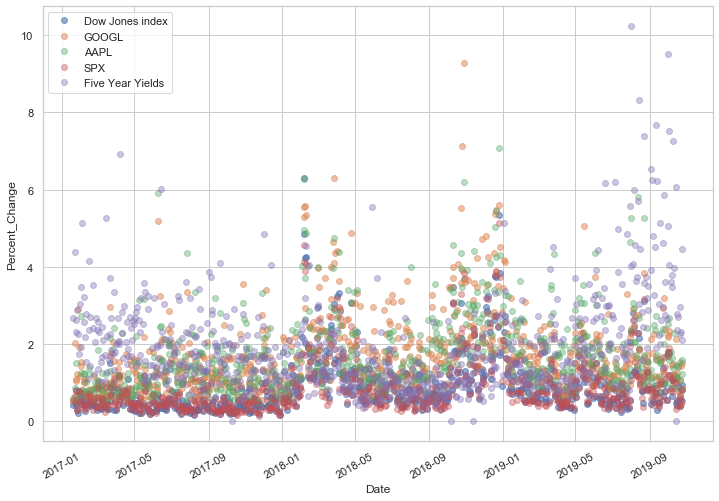

In [175]:
def ImportData(name = "^DJI",source='yahoo',start =datetime.date(2017,1,20), end = datetime.date(2019,10,25) ):
    '''
    This function takes a ticker symbol from a financial data source (yahoo as default), gathering
    daily data from a range start to end.
    
    #### input variables ####
    
        name: the ticker symbol of the stock/index

        source: financial database

        start: starting time of the stock data that the user requests

        end: ending time of the stock data that the user requests 
    
    #### output ####
    
        df: a data frame includes high,low,open,close,volume,adj close, percent_change
    
    ## Attributes ##
    
        high: highest price during the day

        low: lowest price during the day

        open: opening price at 9:30 am

        close: closing price at 4:00 pm

        volume: amount of trading that day

        adj close: I don't really know

        percent_change: (close-open)/open
        
        Rise (categorical): if percent_change > 0
        
        Date: the date

        Volatile (categorical): whether the stock experiences huge change on that day, (high-low)/((high+low)/2) > 5%
    
    '''

    df = web.DataReader(name,source,start,end)
    df['Percent_change'] = (df.High-df.Low)/df.Open*100
    df['Date'] = df.index
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    
    #Change index name to avoid confusion
    df.index.name = "Index"
    
    #sort df according to Date
    df = df.sort_values('Date',ascending=False)

    ### Define the 'Rise' attribute ###
    rise_array = []
    volatile_array = []
    
    percent_mean = np.mean(df['Percent_change'])
    percent_std = np.std(df['Percent_change'])
    volatility_bar = percent_mean + 2*percent_std
    
    for i in range(len(df)):
        if df.iloc[i]['Percent_change']>0:
            rise_array.append(1)
        else:
            rise_array.append(0)
            
        if np.abs(df.iloc[i]['Percent_change'])>volatility_bar:
            volatile_array.append(1)
        else:
            volatile_array.append(0)
            
            
    df['Rise'] = rise_array
    df['Volatile'] = volatile_array
    return df

DJI_data = ImportData('^DJI','yahoo')
AAPL_data = ImportData('AAPL','yahoo')
GOOGL_data = ImportData('GOOGL','yahoo')
df_SPX = ImportData("^GSPC",'yahoo')
FV = ImportData("^FVX",'yahoo')

display(df_SPX.describe())

fig,ax = plt.subplots(1,1,figsize=(12,8))

ax.plot(DJI_data.Date,DJI_data.Percent_change,'o',label = "Dow Jones index",alpha = 0.6)
ax.plot(GOOGL_data.Date,GOOGL_data.Percent_change,'o',label = 'GOOGL',alpha = 0.5)
ax.plot(AAPL_data.Date,AAPL_data.Percent_change,'o',label = 'AAPL',alpha = 0.4)
ax.plot(df_SPX.Date,df_SPX.Percent_change,'o',label = 'SPX',alpha = 0.4)
ax.plot(FV.Date,FV.Percent_change,'o',label = 'Five Year Yields',alpha = 0.4)

ax.set_xlabel("Date")
ax.set_ylabel("Percent_Change")
ax.legend()
plt.xticks(rotation = 30)
plt.show()


In [41]:
np.mean(df_cbm.Percent_change)
np.std(df_cbm.Percent_change)

0.7010255779904415

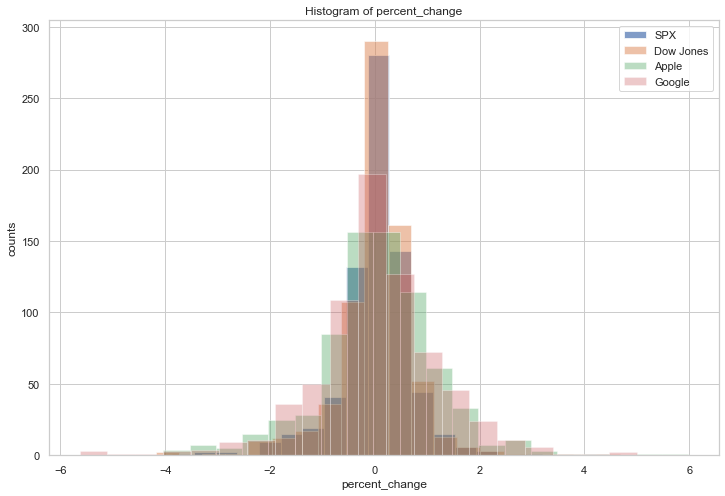

In [18]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(df_SPX.Percent_change,bins=20,label = 'SPX',alpha=0.7)
ax.hist(DJI_data.Percent_change,bins=20,label = 'Dow Jones',alpha=0.5)

ax.hist(AAPL_data.Percent_change,bins=20,label = 'Apple',alpha = 0.4)

ax.hist(GOOGL_data.Percent_change,bins=20,label = 'Google',alpha = 0.3)

ax.set_xlabel('percent_change')
ax.set_ylabel('counts')
ax.legend()
ax.set_title('Histogram of percent_change')
plt.show()

## Combine Tweet and Market Data into a Single Dataset

1. Create a column named trade_date_flag in tweet dataset to indicate whether the date is a trade-day or not

2. Create a combined dataset df_cbm based on df_SPX and add three columns:`trump_tweet_cnt`,`retweet_count`, and `favorite_count`, which indicate the number of tweets Trump tweeted, the number of retweets of Trump's tweets and the number of likes in a particular day



In [176]:
df_tweets_aggr['trade_date_flag'] = [1 if dt in df_SPX['Date'].values else 0 for dt in df_tweets_aggr['created_at']]

df_cbm = df_SPX.copy()
df_cbm['trump_tweet_cnt'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['trump_tweet_cnt'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['retweet_count'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['retweet_count'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['favorite_count'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['favorite_count'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['polarity'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['polarity'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['trade_tags_score'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['trade_tags_score'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['politics_tags_score'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['politics_tags_score'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['foreign_tags_score'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['foreign_tags_score'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]

display(df_cbm.head())
display(df_cbm.describe())

,High,Low,Open,Close,Volume,Adj Close,Percent_change,Date,Rise,Volatile,trump_tweet_cnt,retweet_count,favorite_count,polarity,trade_tags_score,politics_tags_score,foreign_tags_score
Index,,,,,,,,,,,,,,,,,
2019-10-25,3027.389893,3001.939941,3003.320068,3022.550049,3370370000,3022.550049,0.847394,2019-10-25,1,0,1,74119.0,76475.0,3.1,0,4,0
2019-10-24,3016.070068,3000.419922,3014.780029,3010.290039,3692600000,3010.290039,0.519114,2019-10-24,1,0,9,203529.0,518594.0,1.6,0,1,3
2019-10-23,3004.780029,2991.209961,2994.010010,3004.520020,3392870000,3004.520020,0.453241,2019-10-23,1,0,22,604261.0,1292485.0,21.1,4,11,5
2019-10-22,3014.570068,2995.040039,3010.729980,2995.989990,3523890000,2995.989990,0.648681,2019-10-22,1,0,14,504930.0,1022161.0,-1.2,2,9,3
2019-10-21,3007.330078,2995.350098,2996.479980,3006.719971,3271620000,3006.719971,0.399802,2019-10-21,1,0,12,251644.0,645387.0,10.9,0,2,0


,High,Low,Open,Close,Volume,Adj Close,Percent_change,Rise,Volatile,trump_tweet_cnt,retweet_count,favorite_count,polarity,trade_tags_score,politics_tags_score,foreign_tags_score
count,697.000000,697.000000,697.000000,697.000000,6.970000e+02,697.000000,697.000000,697.0,697.000000,697.000000,697.000000,6.970000e+02,697.000000,697.000000,697.000000,697.000000
mean,2693.957344,2670.310731,2682.767102,2682.893888,3.521506e+09,2682.893888,0.876506,1.0,0.053085,9.423242,215300.238164,7.999754e+05,5.574462,3.251076,1.548063,1.179340
std,202.313275,199.377846,201.000998,200.660956,5.920275e+08,200.660956,0.681055,0.0,0.224363,6.008871,139979.556020,4.639871e+05,10.739617,8.715743,2.086024,2.389688
min,2271.780029,2257.020020,2267.780029,2265.199951,1.349780e+09,2265.199951,0.145747,1.0,0.000000,0.000000,0.000000,0.000000e+00,-43.300000,0.000000,0.000000,0.000000
25%,2507.159912,2490.370117,2497.260010,2500.229980,3.192510e+09,2500.229980,0.451209,1.0,0.000000,5.000000,110053.000000,4.484820e+05,-0.400000,0.000000,0.000000,0.000000
50%,2730.600098,2698.750000,2714.989990,2712.969971,3.437620e+09,2712.969971,0.659689,1.0,0.000000,8.000000,193206.000000,7.269610e+05,4.200000,0.000000,1.000000,0.000000
75%,2858.679932,2830.939941,2846.199951,2847.110107,3.770520e+09,2847.110107,1.053383,1.0,0.000000,13.000000,286056.000000,1.077062e+06,11.500000,2.000000,2.000000,1.000000
max,3027.979980,3014.300049,3024.469971,3025.860107,7.609010e+09,3025.860107,5.127963,1.0,1.000000,36.000000,789785.000000,2.639593e+06,59.600000,119.000000,15.000000,26.000000


# EDA and Baseline Model

1. We first perform a scatter plot on all the columns of the combined data frame. At first glance, `high`,`low`,`open`,`close`and `adj close` have some linear relationship with `trump_tweet_cnt`,`retweet_count`, and `favorite_count`. Other columns that are not directly reflecting the price, such as `volume` and `percent_change` seem to be unrelated to `trump_tweet_cnt`,`retweet_count`, or `favorite_count`. 


2. Therefore, we performed a simple linear regression model using `trump_tweet_cnt`, `retweet_count`, and `favorite_count` as predictors and `high` as response variable and calculated the score. The score for the training set is 0.310 and the score for the test set is 0.340. These are pretty bad scores, so we will further process the data and then do the fitting. Lasso regularization can be implemented in the future, too.


3. Then we perform a series of k-NN model using `trump_tweet_cnt`,`retweet_count`, and `favorite_count` as predictors and `high` as response variable and calculate the score. The best scores we get is when number of neighbors is 20. The training set_score is  0.350. The test set score is 0.346.

/Users/shijianjin/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/Users/shijianjin/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/Users/shijianjin/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


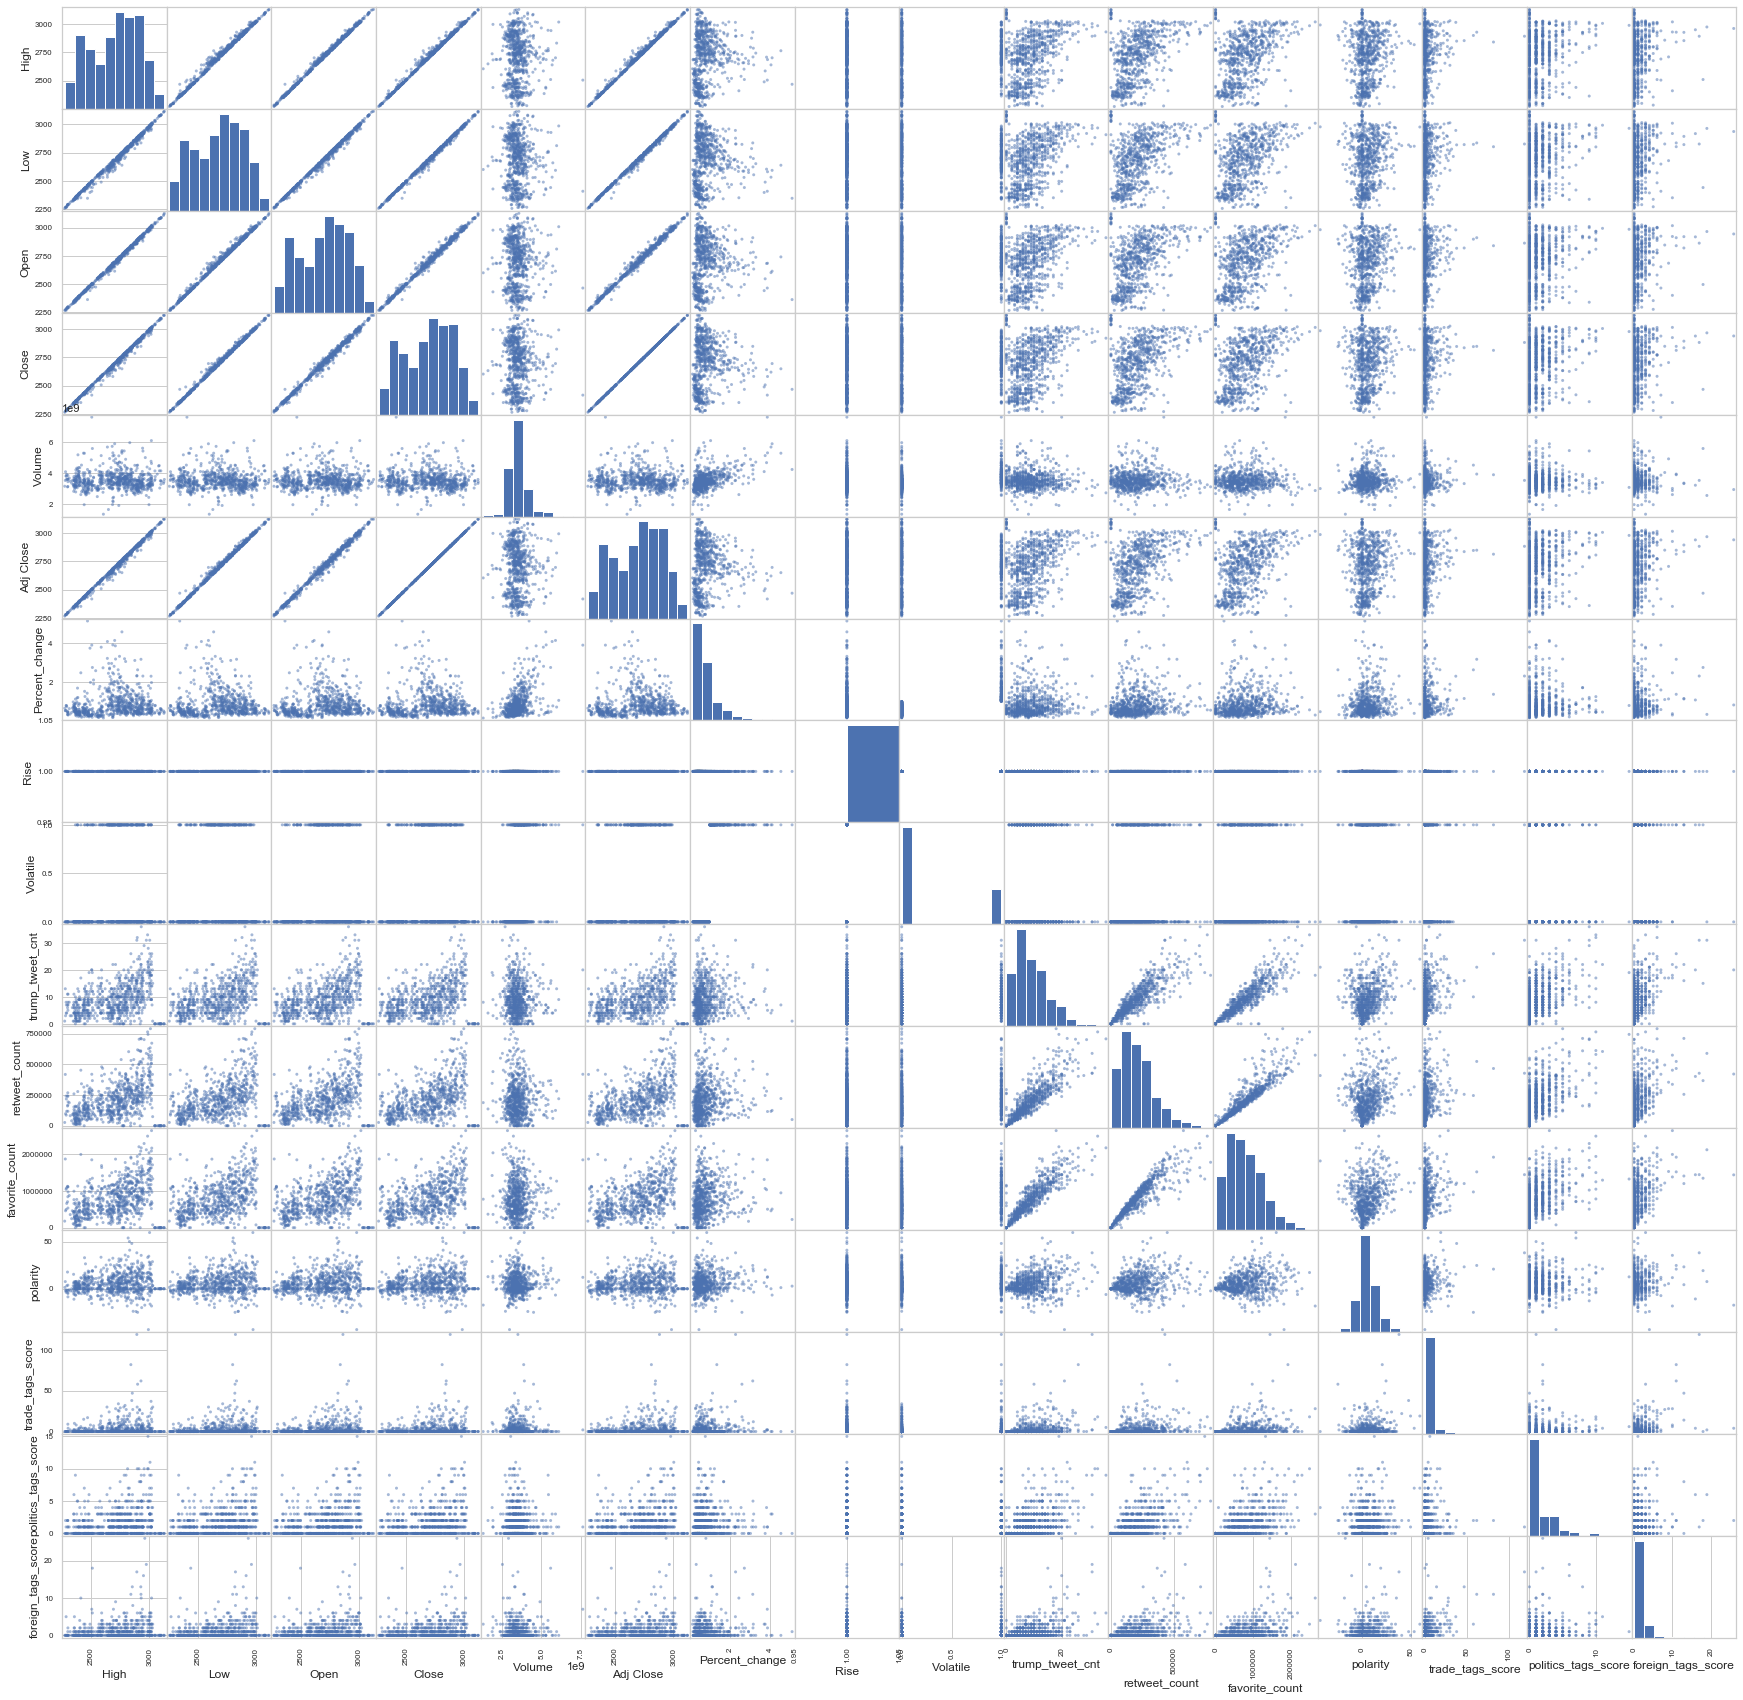

In [44]:
scatter_matrix(df_cbm,figsize=(30,30))
plt.savefig('./scatter_pair.png')
plt.show()

Index
2019-11-19    False
2019-11-18    False
2019-11-15    False
2019-11-14    False
2019-11-13    False
              ...  
2017-01-26    False
2017-01-25    False
2017-01-24    False
2017-01-23    False
2017-01-20    False
Name: Volatile, Length: 714, dtype: bool

In [24]:
combined_df = pd.merge(left=df_tweets_aggr, right=df_SPX, how='left', left_on='created_at', right_on='Date')
combined_df.head()

,created_at,trump_tweet_cnt,trump_retweet_cnt,retweet_count,favorite_count,polarity,trade_tags_score,politics_tags_score,foreign_tags_score,trade_date_flag,High,Low,Open,Close,Volume,Adj Close,Percent_change,Date,Rise,Volatile
0,2017-01-20,13,0,417567.0,1867501.0,7.6,0,0,0,1,2276.959961,2265.010010,2269.959961,2271.310059,3.524970e+09,2271.310059,0.059477,2017-01-20,1.0,0.0
1,2017-01-21,2,1,103818.0,467521.0,5.3,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-22,4,0,184236.0,949408.0,6.6,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-23,1,0,26750.0,177839.0,1.4,0,0,0,1,2271.780029,2257.020020,2267.780029,2265.199951,3.152710e+09,2265.199951,-0.113771,2017-01-23,0.0,0.0
4,2017-01-24,4,0,86707.0,495813.0,-1.2,0,0,0,1,2284.629883,2266.679932,2267.879883,2280.070068,3.810960e+09,2280.070068,0.537515,2017-01-24,1.0,0.0


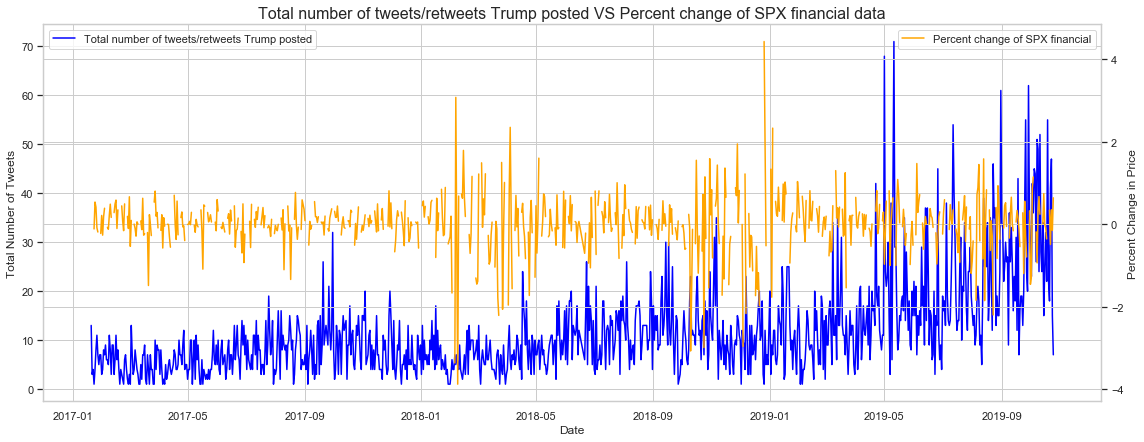

In [25]:
fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(combined_df['created_at'],combined_df['trump_tweet_cnt'] + combined_df['trump_retweet_cnt'], color='blue', label='Total number of tweets/retweets Trump posted')
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Number of Tweets")
plt.legend()
ax2 = ax1.twinx()
ax2.set_ylabel("Percent Change in Price")
ax2.plot(combined_df['created_at'], combined_df['Percent_change'], color='orange', label='Percent change of SPX financial')
fig.tight_layout() 

plt.title('Total number of tweets/retweets Trump posted VS Percent change of SPX financial data', fontsize=16)
plt.legend()
plt.show()

In [ ]:
sns.boxplot(x = 'trade_date_flag', y = 'trump_tweet_cnt', data = combined_df)
plt.title('Trade day or Non-Trade day VS number of Trumps tweets', fontsize=14)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(combined_df['created_at'], combined_df['trump_tweet_cnt'], color='b',alpha=0.7, label='Original tweets')
#ax.scatter(combined_df['created_at'], combined_df['trump_retweet_cnt'], color='r', alpha=0.7, label='Retweets by Trump')
#ax.scatter(combined_df['created_at'], combined_df['retweet_count'], color = 'orange', label = 'Retweets from Trump')
ax.set_xlabel("Date", fontsize = 15)
ax.set_ylabel("Counts",fontsize = 15 )
plt.title('Number of Trump\'s tweets', fontsize=18)
plt.legend(fontsize = 15)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(combined_df['created_at'], combined_df['retweet_count'], color='b',alpha=0.7, label='Retweets of Trump\'s words')
ax.scatter(combined_df['created_at'], combined_df['favorite_count'], color='r', alpha=0.7, label='Favorites')
#ax.scatter(combined_df['created_at'], combined_df['retweet_count'], color = 'orange', label = 'Retweets from Trump')
ax.set_xlabel("Date", fontsize = 15)
ax.set_ylabel("Counts",fontsize = 15 )
plt.title('Retweet of Trump\'s words VS Favorites', fontsize=18)
plt.legend(fontsize = 15)
plt.savefig('/Users/YuhanZhang/Desktop/tweet_2.png')
plt.show()

In [ ]:
# used in the result analysis part
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(combined_df['trump_tweet_cnt'] + combined_df['trump_retweet_cnt'], combined_df['retweet_count'], label="Total retweets")
ax.scatter(combined_df['trump_tweet_cnt'], combined_df['favorite_count'], label="Total favorites")
ax.set_xlabel("The number of tweets",fontsize = 15)
ax.set_ylabel("Counts",fontsize = 15)
plt.title('Total number of tweets/retweets that Trump posted VS number of users who retweet/favorite his tweets', fontsize=18)
plt.legend(fontsize = 15)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(combined_df['created_at'], combined_df['retweet_count'], color='b',alpha=0.7, label='Retweets of Trump\'s words')
ax.scatter(combined_df['created_at'], combined_df['favorite_count'], color='r', alpha=0.7, label='Favorites')
ax.set_xlabel("Date", fontsize = 15)
ax.set_ylabel("Counts",fontsize = 15 )
plt.title('Retweet of Trump\'s words VS Favorites', fontsize=18)
plt.legend(fontsize = 15)
#plt.savefig('/Users/YuhanZhang/Desktop/tweet_2.png')
plt.show()

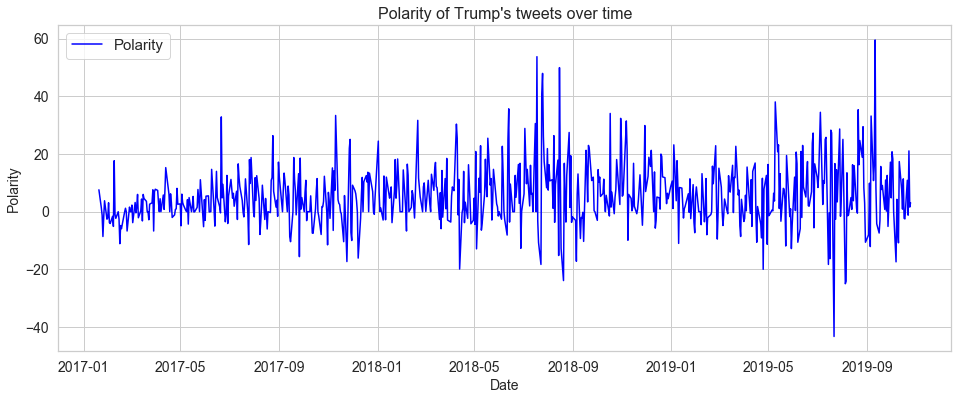

In [196]:
#2019-12-10 New

fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(df_cbm['Date'],df_cbm['polarity'], color='blue', label='Polarity')
ax1.set_xlabel("Date",fontsize=14)
ax1.set_ylabel("Polarity",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Polarity of Trump\'s tweets over time' , fontsize=16)
plt.legend(fontsize = 15)
plt.show()

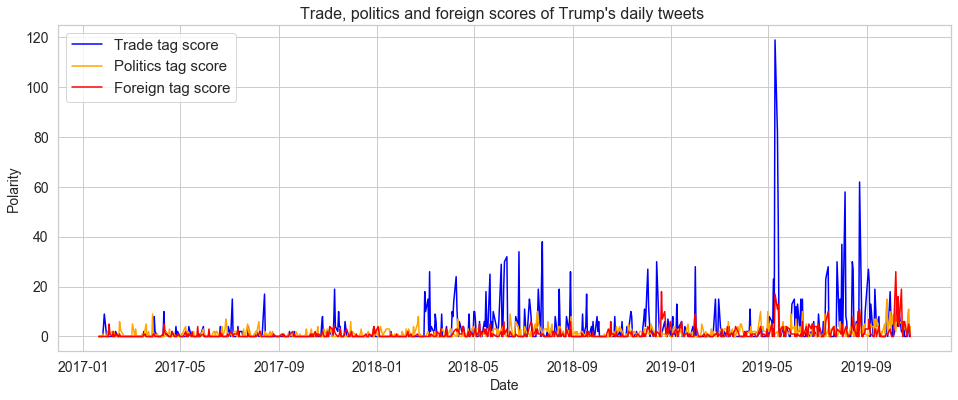

In [197]:

fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(df_cbm['Date'],df_cbm['trade_tags_score'], color='blue', label='Trade tag score')
ax1.plot(df_cbm['Date'],df_cbm['politics_tags_score'],color='orange',  label='Politics tag score')
ax1.plot(df_cbm['Date'],df_cbm['foreign_tags_score'],color='red', label='Foreign tag score')

ax1.set_xlabel("Date",fontsize=14)
ax1.set_ylabel("Polarity",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Trade, politics and foreign scores of Trump\'s daily tweets ', fontsize=16)
plt.legend(fontsize = 15)
plt.show()

## Basic modelling

In [207]:


#df_cbm = df_cbm.iloc[17:] #only run once to drop the row of zeros

display(df_cbm.describe())

x = df_cbm[['trump_tweet_cnt','retweet_count','favorite_count','polarity','trade_tags_score','politics_tags_score','foreign_tags_score']]

y = df_cbm['High']

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

reg = LinearRegression().fit(X_train,y_train)
train_score = reg.score(X_train,y_train)
test_score = reg.score(X_test,y_test)
print("The training set_score is ",train_score,". The test set score is",test_score)

display(X_train.head())

,High,Low,Open,Close,Volume,Adj Close,Percent_change,Rise,Volatile,trump_tweet_cnt,retweet_count,favorite_count,polarity,trade_tags_score,politics_tags_score,foreign_tags_score
count,697.000000,697.000000,697.000000,697.000000,6.970000e+02,697.000000,697.000000,697.0,697.000000,697.000000,697.000000,6.970000e+02,697.000000,697.000000,697.000000,697.000000
mean,2693.957344,2670.310731,2682.767102,2682.893888,3.521506e+09,2682.893888,0.876506,1.0,0.053085,9.423242,215300.238164,7.999754e+05,5.574462,3.251076,1.548063,1.179340
std,202.313275,199.377846,201.000998,200.660956,5.920275e+08,200.660956,0.681055,0.0,0.224363,6.008871,139979.556020,4.639871e+05,10.739617,8.715743,2.086024,2.389688
min,2271.780029,2257.020020,2267.780029,2265.199951,1.349780e+09,2265.199951,0.145747,1.0,0.000000,0.000000,0.000000,0.000000e+00,-43.300000,0.000000,0.000000,0.000000
25%,2507.159912,2490.370117,2497.260010,2500.229980,3.192510e+09,2500.229980,0.451209,1.0,0.000000,5.000000,110053.000000,4.484820e+05,-0.400000,0.000000,0.000000,0.000000
50%,2730.600098,2698.750000,2714.989990,2712.969971,3.437620e+09,2712.969971,0.659689,1.0,0.000000,8.000000,193206.000000,7.269610e+05,4.200000,0.000000,1.000000,0.000000
75%,2858.679932,2830.939941,2846.199951,2847.110107,3.770520e+09,2847.110107,1.053383,1.0,0.000000,13.000000,286056.000000,1.077062e+06,11.500000,2.000000,2.000000,1.000000
max,3027.979980,3014.300049,3024.469971,3025.860107,7.609010e+09,3025.860107,5.127963,1.0,1.000000,36.000000,789785.000000,2.639593e+06,59.600000,119.000000,15.000000,26.000000


The training set_score is  0.3055479428994057 . The test set score is 0.2621202224564284


,trump_tweet_cnt,retweet_count,favorite_count,polarity,trade_tags_score,politics_tags_score,foreign_tags_score
Index,,,,,,,
2019-07-01,19,308622.0,1472199.0,12.0,0,0,4
2019-08-14,17,384068.0,1231423.0,16.3,30,1,4
2018-12-11,13,266889.0,1165368.0,13.8,2,2,1
2017-08-08,4,125388.0,380389.0,-7.9,0,1,2
2018-01-10,10,188835.0,821099.0,6.0,0,2,0


### Normalize Data

In [198]:
from sklearn import preprocessing

# fit the scaler on the X_train
scaler = preprocessing.MinMaxScaler().fit(X_train)

# Scale X_train and X_test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Making the numpy scaled matrices pandas dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

X_train_scaled_df.head()

,trump_tweet_cnt,retweet_count,favorite_count,polarity,trade_tags_score,politics_tags_score,foreign_tags_score
0,0.222222,0.202212,0.236367,0.511843,0.032258,0.090909,0.263158
1,0.055556,0.019301,0.027864,0.473738,0.000000,0.000000,0.000000
2,0.055556,0.045782,0.063869,0.488157,0.000000,0.000000,0.000000
3,0.555556,0.508052,0.545550,0.334706,0.064516,0.545455,0.842105
4,0.194444,0.153257,0.219874,0.445932,0.064516,0.000000,0.157895


#### Update model with normalized data

In [174]:
reg_scaled = LinearRegression().fit(X_train_scaled_df,y_train)
train_score_scaled = reg.score(X_train_scaled_df,y_train)
test_score_scaled = reg.score(X_test_scaled_df,y_test)
print("The training set score is ",train_score_scaled,". The test set score is",test_score_scaled)

The training set score is  -0.0730839296824517 . The test set score is -0.14545236774538628


In [ ]:
fig, ax = plt.subplots(1,3, figsize = (20,6))
predictor = list(['trump_tweet_cnt','retweet_count','favorite_count'])
name = ['Trump\'s original tweets', 'Number of retweets', 'Number of favorite']
for i, item in enumerate(predictor):
    ax[i].scatter(df_cbm[item], y)
    ax[i].set_title('Highest price during the day & {}'.format(name[i]), fontsize = 15)
    ax[i].set_xlabel('Number')
    ax[i].set_ylabel('Number')



The number of neighbors is 1 The training set_score is  0.9867709397706813 . The test set score is -0.423347016620073
The number of neighbors is 2 The training set_score is  0.7023025553252018 . The test set score is 0.030451099410673917
The number of neighbors is 3 The training set_score is  0.5885100128545917 . The test set score is 0.15291238659357276
The number of neighbors is 5 The training set_score is  0.474554773512725 . The test set score is 0.20218153304656494
The number of neighbors is 6 The training set_score is  0.4551624558756089 . The test set score is 0.23168312467101237
The number of neighbors is 7 The training set_score is  0.4411205824111237 . The test set score is 0.2412945126522704
The number of neighbors is 8 The training set_score is  0.4183815227032589 . The test set score is 0.2567931752506959
The number of neighbors is 10 The training set_score is  0.3852110585550283 . The test set score is 0.253274077099936
The number of neighbors is 20 The training set_score

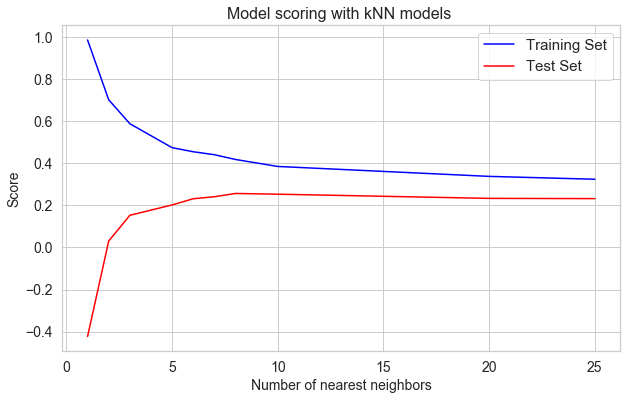

In [226]:
k_list = [1,2,3,5,6,7,8,10,20,25]
train_score_set = []
test_score_set = []
for k in k_list:
    kNN = KNeighborsRegressor(n_neighbors = k).fit(X_train,y_train)

    train_score = kNN.score(X_train,y_train)
    test_score = kNN.score(X_test,y_test)
    train_score_set.append(train_score)
    test_score_set.append(test_score)
    print("The number of neighbors is",k,"The training set_score is ",train_score,". The test set score is",test_score)
    
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(k_list,train_score_set, color='blue', label='Training Set')
ax1.plot(k_list,test_score_set,color='red',  label='Test Set')

ax1.set_xlabel("Number of nearest neighbors",fontsize=14)
ax1.set_ylabel("Score",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Model scoring with kNN models ', fontsize=16)
plt.legend(fontsize = 15)
plt.show()

# Tree Model Fitting



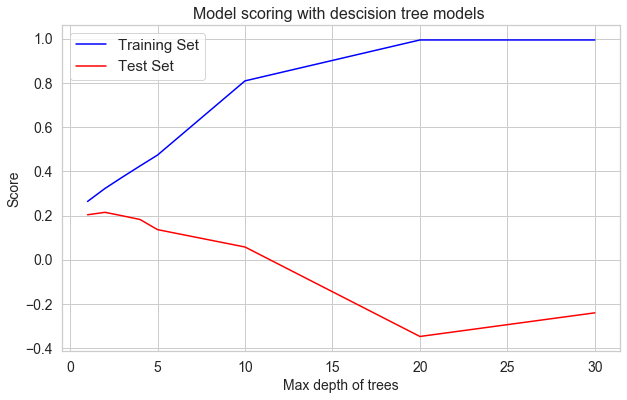

In [225]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,accuracy_score

max_depth = [1,2,3,4,5,10,20,30]
tree_models = []
tree_train_score = []
tree_cross_score = []
tree_test_score = []
for depth in max_depth:
    
    dtree = DecisionTreeRegressor(max_depth=depth)
    dtree.fit(X_train,y_train)
    train_score = dtree.score(X_train,y_train)
    cross_scores = np.mean(cross_val_score(dtree,X_train,y_train,cv=5))
    tree_models.append(dtree)
    tree_train_score.append(train_score)
    tree_cross_score.append(cross_scores)
    tree_test_score.append(dtree.score(X_test,y_test))

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(max_depth,tree_train_score, color='blue', label='Training Set')
ax1.plot(max_depth,tree_test_score,color='red',  label='Test Set')

ax1.set_xlabel("Max depth of trees",fontsize=14)
ax1.set_ylabel("Score",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Model scoring with descision tree models ', fontsize=16)
plt.legend(fontsize = 15)
plt.show()


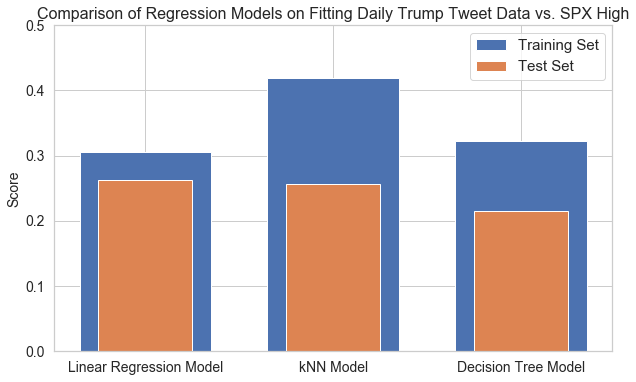

In [224]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

ax.bar(['Linear Regression Model','kNN Model','Decision Tree Model'],[train_score,train_score_set[6],tree_train_score[1]],label='Training Set',width=0.7)
ax.bar(['Linear Regression Model','kNN Model','Decision Tree Model'],[test_score,test_score_set[6],tree_test_score[1]],label='Test Set',width=0.5)
ax.legend(fontsize=15)
ax.set_ylabel("Score",fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.set_ylim(0,0.5)
ax.set_title('Comparison of Regression Models on Fitting Daily Trump Tweet Data vs. SPX High',fontsize=16)
plt.show()


### ANN



In [31]:
import tensorflow as tf


In [218]:
input_dimension = X_train.shape[1]
output_dimension = 1
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,input_dim = input_dimension,kernel_initializer = 'normal'),
    tf.keras.layers.Dense(20,activation = 'relu',kernel_initializer = 'normal'),
    tf.keras.layers.Dense(15,activation = 'relu',kernel_initializer = 'normal'),
    tf.keras.layers.Dense(20,activation = 'relu',kernel_initializer = 'normal'),
    tf.keras.layers.Dense(10,activation = 'relu',kernel_initializer = 'normal'),

    tf.keras.layers.Dense(output_dimension,activation = 'linear'),

])

model.compile(optimizer = 'adam',loss='mean_absolute_error',metrics=['accuracy'])
model.summary()

history = model.fit(X_train,y_train,validation_split=0.2,epochs=500,batch_size=32)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 10)                80        
_________________________________________________________________
dense_73 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_74 (Dense)             (None, 15)                315       
_________________________________________________________________
dense_75 (Dense)             (None, 20)                320       
_________________________________________________________________
dense_76 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 11        
Total params: 1,156
Trainable params: 1,156
Non-trainable params: 0
___________________________________________________

Epoch 94/500
445/445 [==============================] - 0s 44us/sample - loss: 1108.4954 - accuracy: 0.0000e+00 - val_loss: 1116.8725 - val_accuracy: 0.0000e+00
Epoch 95/500
445/445 [==============================] - 0s 45us/sample - loss: 1099.7929 - accuracy: 0.0000e+00 - val_loss: 1108.6439 - val_accuracy: 0.0000e+00
Epoch 96/500
445/445 [==============================] - 0s 40us/sample - loss: 1100.9232 - accuracy: 0.0000e+00 - val_loss: 1112.7017 - val_accuracy: 0.0000e+00
Epoch 97/500
445/445 [==============================] - 0s 70us/sample - loss: 1108.4891 - accuracy: 0.0000e+00 - val_loss: 1098.8074 - val_accuracy: 0.0000e+00
Epoch 98/500
445/445 [==============================] - 0s 76us/sample - loss: 1100.9399 - accuracy: 0.0000e+00 - val_loss: 1111.9083 - val_accuracy: 0.0000e+00
Epoch 99/500
445/445 [==============================] - 0s 83us/sample - loss: 1104.0001 - accuracy: 0.0000e+00 - val_loss: 1122.6248 - val_accuracy: 0.0000e+00
Epoch 100/500
445/445 [===========

Epoch 195/500
445/445 [==============================] - 0s 45us/sample - loss: 1084.6573 - accuracy: 0.0000e+00 - val_loss: 1114.2837 - val_accuracy: 0.0000e+00
Epoch 196/500
445/445 [==============================] - 0s 47us/sample - loss: 1088.2399 - accuracy: 0.0000e+00 - val_loss: 1121.9117 - val_accuracy: 0.0000e+00
Epoch 197/500
445/445 [==============================] - 0s 42us/sample - loss: 1090.6101 - accuracy: 0.0000e+00 - val_loss: 1108.2039 - val_accuracy: 0.0000e+00
Epoch 198/500
445/445 [==============================] - 0s 42us/sample - loss: 1092.4554 - accuracy: 0.0000e+00 - val_loss: 1118.2280 - val_accuracy: 0.0000e+00
Epoch 199/500
445/445 [==============================] - 0s 39us/sample - loss: 1089.7400 - accuracy: 0.0000e+00 - val_loss: 1109.2893 - val_accuracy: 0.0000e+00
Epoch 200/500
445/445 [==============================] - 0s 43us/sample - loss: 1087.3672 - accuracy: 0.0000e+00 - val_loss: 1115.9335 - val_accuracy: 0.0000e+00
Epoch 201/500
445/445 [=====

Epoch 296/500
445/445 [==============================] - 0s 70us/sample - loss: 1083.2275 - accuracy: 0.0000e+00 - val_loss: 1135.1845 - val_accuracy: 0.0000e+00
Epoch 297/500
445/445 [==============================] - 0s 57us/sample - loss: 1072.7192 - accuracy: 0.0000e+00 - val_loss: 1109.2941 - val_accuracy: 0.0000e+00
Epoch 298/500
445/445 [==============================] - 0s 46us/sample - loss: 1080.4665 - accuracy: 0.0000e+00 - val_loss: 1114.9948 - val_accuracy: 0.0000e+00
Epoch 299/500
445/445 [==============================] - 0s 47us/sample - loss: 1094.3586 - accuracy: 0.0000e+00 - val_loss: 1121.9842 - val_accuracy: 0.0000e+00
Epoch 300/500
445/445 [==============================] - 0s 49us/sample - loss: 1079.9569 - accuracy: 0.0000e+00 - val_loss: 1105.8717 - val_accuracy: 0.0000e+00
Epoch 301/500
445/445 [==============================] - 0s 38us/sample - loss: 1077.4417 - accuracy: 0.0000e+00 - val_loss: 1118.4906 - val_accuracy: 0.0000e+00
Epoch 302/500
445/445 [=====

Epoch 397/500
445/445 [==============================] - 0s 93us/sample - loss: 1071.5437 - accuracy: 0.0000e+00 - val_loss: 1081.9555 - val_accuracy: 0.0000e+00
Epoch 398/500
445/445 [==============================] - 0s 95us/sample - loss: 1071.9370 - accuracy: 0.0000e+00 - val_loss: 1107.1771 - val_accuracy: 0.0000e+00
Epoch 399/500
445/445 [==============================] - 0s 76us/sample - loss: 1065.9631 - accuracy: 0.0000e+00 - val_loss: 1121.6489 - val_accuracy: 0.0000e+00
Epoch 400/500
445/445 [==============================] - 0s 77us/sample - loss: 1075.5949 - accuracy: 0.0000e+00 - val_loss: 1113.6314 - val_accuracy: 0.0000e+00
Epoch 401/500
445/445 [==============================] - 0s 88us/sample - loss: 1078.0199 - accuracy: 0.0000e+00 - val_loss: 1200.0593 - val_accuracy: 0.0000e+00
Epoch 402/500
445/445 [==============================] - 0s 99us/sample - loss: 1064.4042 - accuracy: 0.0000e+00 - val_loss: 1102.1126 - val_accuracy: 0.0000e+00
Epoch 403/500
445/445 [=====

445/445 [==============================] - 0s 53us/sample - loss: 1079.3207 - accuracy: 0.0000e+00 - val_loss: 1138.6512 - val_accuracy: 0.0000e+00
Epoch 498/500
445/445 [==============================] - 0s 53us/sample - loss: 1077.5155 - accuracy: 0.0000e+00 - val_loss: 1083.7197 - val_accuracy: 0.0000e+00
Epoch 499/500
445/445 [==============================] - 0s 50us/sample - loss: 1064.8141 - accuracy: 0.0000e+00 - val_loss: 1099.9119 - val_accuracy: 0.0000e+00
Epoch 500/500
445/445 [==============================] - 0s 51us/sample - loss: 1063.1603 - accuracy: 0.0000e+00 - val_loss: 1086.7906 - val_accuracy: 0.0000e+00


In [35]:
from sklearn.metrics import accuracy_score

,High,Low,Open,Close,Volume,Adj Close,Percent_change,Date,Rise,Volatile,trump_tweet_cnt,retweet_count,favorite_count,polarity,trade_tags_score,politics_tags_score,foreign_tags_score
Index,,,,,,,,,,,,,,,,,
2019-10-25,3027.389893,3001.939941,3003.320068,3022.550049,3370370000,3022.550049,0.640291,2019-10-25,1,0,1,74119.0,76475.0,3.1,0,4,0
2019-10-24,3016.070068,3000.419922,3014.780029,3010.290039,3692600000,3010.290039,-0.148933,2019-10-24,0,0,9,203529.0,518594.0,1.6,0,1,3
2019-10-23,3004.780029,2991.209961,2994.010010,3004.520020,3392870000,3004.520020,0.351035,2019-10-23,1,0,22,604261.0,1292485.0,21.1,4,11,5
2019-10-22,3014.570068,2995.040039,3010.729980,2995.989990,3523890000,2995.989990,-0.489582,2019-10-22,0,0,14,504930.0,1022161.0,-1.2,2,9,3
2019-10-21,3007.330078,2995.350098,2996.479980,3006.719971,3271620000,3006.719971,0.341734,2019-10-21,1,0,12,251644.0,645387.0,10.9,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-26,2300.989990,2294.080078,2298.629883,2296.679932,3610360000,2296.679932,-0.084831,2017-01-26,0,0,11,194173.0,970602.0,-1.7,4,0,0
2017-01-25,2299.550049,2288.879883,2288.879883,2298.370117,3846020000,2298.370117,0.414624,2017-01-25,1,0,8,240014.0,1112361.0,-8.6,0,1,0
2017-01-24,2284.629883,2266.679932,2267.879883,2280.070068,3810960000,2280.070068,0.537515,2017-01-24,1,0,4,86707.0,495813.0,-1.2,0,0,0


### Try Classification of Volatility

In [254]:


volatile_df = df_cbm[df_cbm.Volatile==True]

x = df_cbm[['trump_tweet_cnt','retweet_count','favorite_count','polarity','trade_tags_score','politics_tags_score','foreign_tags_score']]

y = df_cbm['Volatile']


X_train,X_test,y_train2,y_test2 = train_test_split(x,y,test_size=0.5,random_state=42,stratify=y)


#Add duplicates to X
'''
new_training = X_train
new_training['Volatile'] = y


volatile_df = new_training[new_training['Volatile']==1]

new_training = new_training.append([volatile_df]*5,ignore_index=True)
display(volatile_df.head(10))

y_train2 = new_training.Volatile
X_train = new_training.drop(['Volatile'],axis=1)

'''
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

# fit the scaler on the X_train
scaler = preprocessing.MinMaxScaler().fit(X_train)

# Scale X_train and X_test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Making the numpy scaled matrices pandas dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

X_train_scaled_df.head()


logistic_model = LogisticRegression(C=1000000)
logistic_model.fit(X_train_scaled,y_train2)
print("Training set score after normalization",logistic_model.score(X_train_scaled,y_train2))
print("Test set score after normalization",logistic_model.score(X_test_scaled,y_test2))


Training set score after normalization 0.9454022988505747
Test set score after normalization 0.9426934097421203


/Users/shijianjin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Logistic Regression with Regularization

In [245]:
logistic_model_regularized = LogisticRegression(C=0.1)
logistic_model_regularized.fit(X_train_scaled,y_train2)
print("Training set score",logistic_model_regularized.score(X_train_scaled,y_train2))
print("Test set score",logistic_model_regularized.score(X_test_scaled,y_test2))

Training set score 0.9482758620689655
Test set score 0.9455587392550143


/Users/shijianjin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Try KNN classifier on volatility

The number of neighbors is 1 The training set_score is  1.0 . The validation set score is 0.9138302277432713 The test set score is 0.9197707736389685
The number of neighbors is 2 The training set_score is  0.9568965517241379 . The validation set score is 0.9454244306418218 The test set score is 0.9455587392550143
The number of neighbors is 3 The training set_score is  0.9597701149425287 . The validation set score is 0.9368115942028984 The test set score is 0.9398280802292264
The number of neighbors is 5 The training set_score is  0.9511494252873564 . The validation set score is 0.9483229813664595 The test set score is 0.9455587392550143
The number of neighbors is 6 The training set_score is  0.9482758620689655 . The validation set score is 0.9483229813664595 The test set score is 0.9455587392550143
The number of neighbors is 7 The training set_score is  0.9482758620689655 . The validation set score is 0.9483229813664595 The test set score is 0.9455587392550143
The number of neighbors i

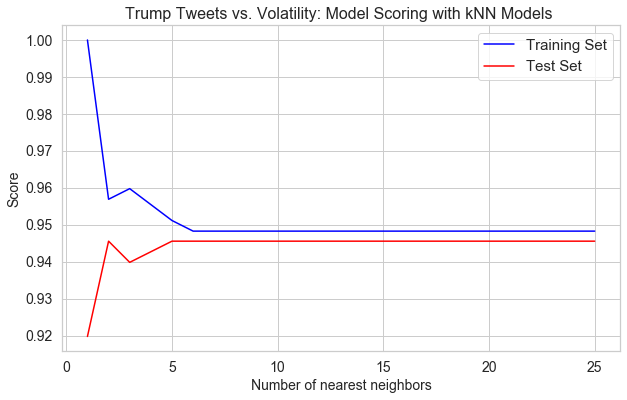

In [246]:
from sklearn.neighbors import KNeighborsClassifier


k_list = [1,2,3,5,6,7,8,10,20,25]
k_cross_scores = []
k_train_scores = []
k_test_scores = []
for k in k_list:
    kNN = KNeighborsClassifier(n_neighbors = k).fit(X_train_scaled,y_train2)

    train_score = kNN.score(X_train_scaled,y_train2)
    cross_score = np.mean(cross_val_score(kNN,X_train_scaled,y_train2,cv=5))
    test_score = kNN.score(X_test_scaled,y_test2)
    k_train_scores.append(train_score)
    k_cross_scores.append(cross_score)
    k_test_scores.append(test_score)
    
    print("The number of neighbors is",k,"The training set_score is ",train_score,". The validation set score is",cross_score,"The test set score is",test_score)
    
    
    
    
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(k_list,k_train_scores, color='blue', label='Training Set')
ax1.plot(k_list,k_test_scores,color='red',  label='Test Set')

ax1.set_xlabel("Number of nearest neighbors",fontsize=14)
ax1.set_ylabel("Score",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Trump Tweets vs. Volatility: Model Scoring with kNN Models ', fontsize=16)
plt.legend(fontsize = 15)
plt.show()
    

### Decision Tree Model Classifier

The max depth is 1 The training set_score is  0.9540229885057471 . The validation set score is 0.9540786749482401 The test set score is 0.9455587392550143
The max depth is 2 The training set_score is  0.9540229885057471 . The validation set score is 0.9512215320910972 The test set score is 0.9455587392550143
The max depth is 3 The training set_score is  0.9597701149425287 . The validation set score is 0.9455072463768115 The test set score is 0.9398280802292264
The max depth is 4 The training set_score is  0.9655172413793104 . The validation set score is 0.9454658385093166 The test set score is 0.9426934097421203
The max depth is 5 The training set_score is  0.9655172413793104 . The validation set score is 0.9483643892339544 The test set score is 0.9426934097421203
The max depth is 10 The training set_score is  0.9942528735632183 . The validation set score is 0.9195859213250517 The test set score is 0.9025787965616046
The max depth is 20 The training set_score is  1.0 . The validation s

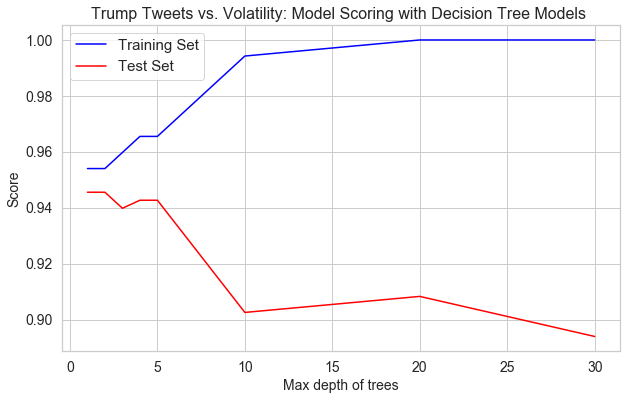

In [247]:
from sklearn.tree import DecisionTreeClassifier


max_depth = [1,2,3,4,5,10,20,30]
tree_models = []
tree_train_score = []
tree_cross_score = []
tree_test_score = []
for depth in max_depth:
    
    dtree = DecisionTreeClassifier(max_depth=depth)
    dtree.fit(X_train_scaled,y_train2)
    train_score = dtree.score(X_train_scaled,y_train2)
    test_score = dtree.score(X_test_scaled,y_test2)
    cross_score = np.mean(cross_val_score(dtree,X_train_scaled,y_train2,cv=5))
    tree_models.append(dtree)
    tree_train_score.append(train_score)
    tree_cross_score.append(cross_score)
    tree_test_score.append(test_score)
    print("The max depth is",depth,"The training set_score is ",train_score,". The validation set score is",cross_score,"The test set score is",test_score)

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(max_depth,tree_train_score, color='blue', label='Training Set')
ax1.plot(max_depth,tree_test_score,color='red',  label='Test Set')

ax1.set_xlabel("Max depth of trees",fontsize=14)
ax1.set_ylabel("Score",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Trump Tweets vs. Volatility: Model Scoring with Decision Tree Models ', fontsize=16)
plt.legend(fontsize = 15)
plt.show()


### ANN Model

In [250]:
input_dimension = X_train_scaled.shape[1]
output_dimension = 1
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,input_dim = input_dimension,kernel_initializer = 'normal'),
    tf.keras.layers.Dense(20,activation = 'relu',kernel_initializer = 'normal'),
    tf.keras.layers.Dense(50,activation = 'relu',kernel_initializer = 'normal'),
    tf.keras.layers.Dense(20,activation = 'relu',kernel_initializer = 'normal'),
    tf.keras.layers.Dense(10,activation = 'relu',kernel_initializer = 'normal'),

    tf.keras.layers.Dense(output_dimension,activation = 'sigmoid'),

])

model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

history = model.fit(X_train,y_train2,validation_split=0.2,epochs=100,batch_size=50)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 10)                80        
_________________________________________________________________
dense_91 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_92 (Dense)             (None, 50)                1050      
_________________________________________________________________
dense_93 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_94 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 11        
Total params: 2,591
Trainable params: 2,591
Non-trainable params: 0
___________________________________________________

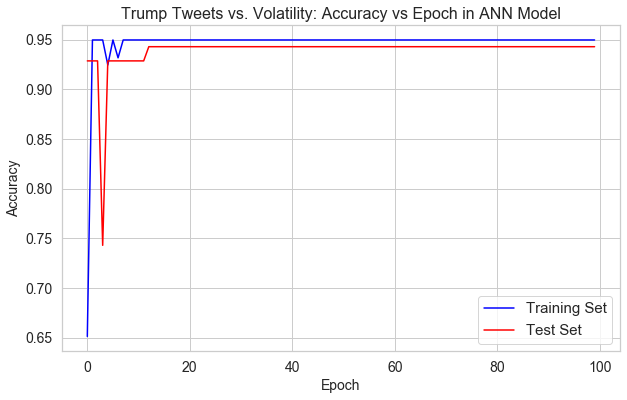

In [253]:


fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(np.array(history.history['accuracy']), color='blue', label='Training Set')
ax1.plot(np.array(history.history['val_accuracy']),color ='red',  label='Test Set')

ax1.set_xlabel("Epoch",fontsize=14)
ax1.set_ylabel("Accuracy",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Trump Tweets vs. Volatility: Accuracy vs Epoch in ANN Model', fontsize=16)
plt.legend(fontsize = 15)
plt.show()

0.9455587392550143


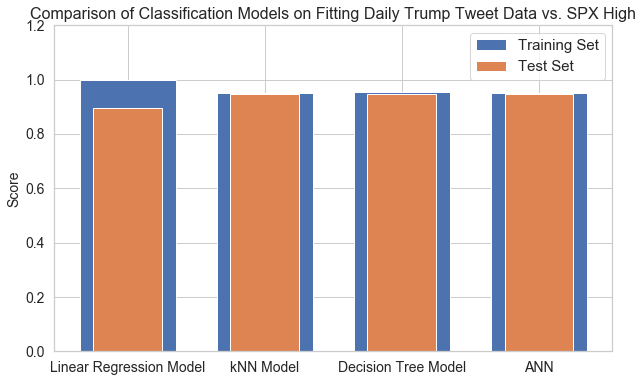

In [271]:
print(accuracy_score(y_test2,np.rint(model.predict(X_test_scaled))))

fig,ax = plt.subplots(1,1,figsize=(10,6))

ax.bar(['Linear Regression Model','kNN Model','Decision Tree Model','ANN'],[train_score,k_train_scores[3],tree_train_score[1],np.array(history.history['accuracy'])[-1]],label='Training Set',width=0.7)
ax.bar(['Linear Regression Model','kNN Model','Decision Tree Model','ANN'],[test_score,k_test_scores[3],tree_test_score[1],accuracy_score(y_test2,np.rint(model.predict(X_test_scaled)))],label='Test Set',width=0.5)
ax.legend(fontsize=15)
ax.set_ylabel("Score",fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.set_ylim(0,1.2)
ax.set_title('Comparison of Classification Models on Fitting Daily Trump Tweet Data vs. SPX High',fontsize=16)
plt.show()

# Future Work

1. The baseline model clearly gives terrible fitting. The failure is due to the lack of proper predictors. The number of tweets by Trump does not mean much to the market; rather, it's the content in those tweets that matters more. A simple modification on the current dataset is to have a column named ave_retweet or ave_favorite, whose value is `retweet_count`/`trump_tweet_cnt` or `favorite_count`/`trump_tweet_cnt`. This column would reflect the importance of the tweets at a particular day. We expect important tweets have more influence on the market.

2. An important task to do is to categorize the tweets based on the content. Possible categories are, whether a tweet mentions market(e.g. mentions a company's name or an industry), whether a tweet mentions trade war, whether a tweet expresses positive or negative attitude, whether a tweet uses strong language or not. After categorization, we may use models such as decision tree to find out the most important features that influence the market.

3. We will find out the most frequent phrases that Trump uses in the tweets and check how the appearance of these phrases influence market behavior.

4. We can include more features into the market data. For example, we can have a column named big_change, indicating whether the stock/index experiences a change that is way larger than $2*std$. 


# Topic Modeling - Tweets text

## Theoretical Overview

LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.    
    
We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:    
psi -- the distribution of words for each topic K    
phi -- the distribution of topics for each document i    

In [ ]:
print('Total tweets', len(df_tweets))
df_tweets.head()

In [ ]:
def grep_ref_tweet_ids(text):
    ref_tweet_ids=[]
    ref_tweet_ids = re.findall(r'@(\w+)\W',text)
    #clean_text= re.sub(r'@(\w+)\W', r' ', text)
    return ref_tweet_ids, clean_text

In [ ]:
def grep_hash_tags(text):
    ref_hash_tags=[]
    ref_hash_tags = re.findall(r'#([\w]{3,})\W',text)
    clean_text= text #re.sub(r'#([\w]{3,})\W', r' ', text)
    return ref_hash_tags, clean_text

In [ ]:
def grep_ref_https_link(text):
    ref_http_links=[]
    ref_http_links=[]
    ref_http_links = re.findall(r'(https?://[\w\.\/]+)\W',text)
    clean_text=text
    return ref_http_links, clean_text

In [ ]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [ ]:
# Load the regular expression library
import re

# Remove punctuation
df_tweets['tweet_text_processed'] = df_tweets['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the tweets to lowercase
df_tweets['tweet_text_processed'] = df_tweets['tweet_text_processed'].map(lambda x: x.lower())

# Print out the few rows of tweets
df_tweets['tweet_text_processed'].head()

### Exploratory Analysis - WordCloud

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed tweets together
long_string = ','.join(list(df_tweets['tweet_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### Prepare text for LDA analysis

In [ ]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed tweets
count_data = count_vectorizer.fit_transform(df_tweets['tweet_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

### LDA model tranining

In [ ]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)